In [1]:
!pip install Prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.4/13.3 MB 12.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/13.3 MB 21.1 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 24.5 MB/s eta 0:00:01
   ------------ --------------------------- 4.3/13.3 MB 24.9 MB/s eta 0:00:01
   --------------- ------------------------ 5.3/13.3 MB 24.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.6/13.3 MB 24.9 MB/s eta 0:00:01
   ------------------------ --------------- 8.1/13.3 MB 25.7 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.3 MB 26.2 MB/s eta 0:00:01
   -------------------------------- ------- 10.7/13.3 MB 28.4 MB/s eta 0:00:01
   ----------------------------------- ---- 11.7/13.3 MB 27.3 MB/s eta 0:00:01
   ------------------------------------- -- 12.6/13.3 MB 26.2 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 26.2 MB/s et

In [2]:
#pip install seaborn

In [3]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing



Forecast Metrics:
Root Mean Square Error (RMSE): 0.573
Mean Absolute Percentage Error (MAPE): 5.36%
R² Score: 0.613


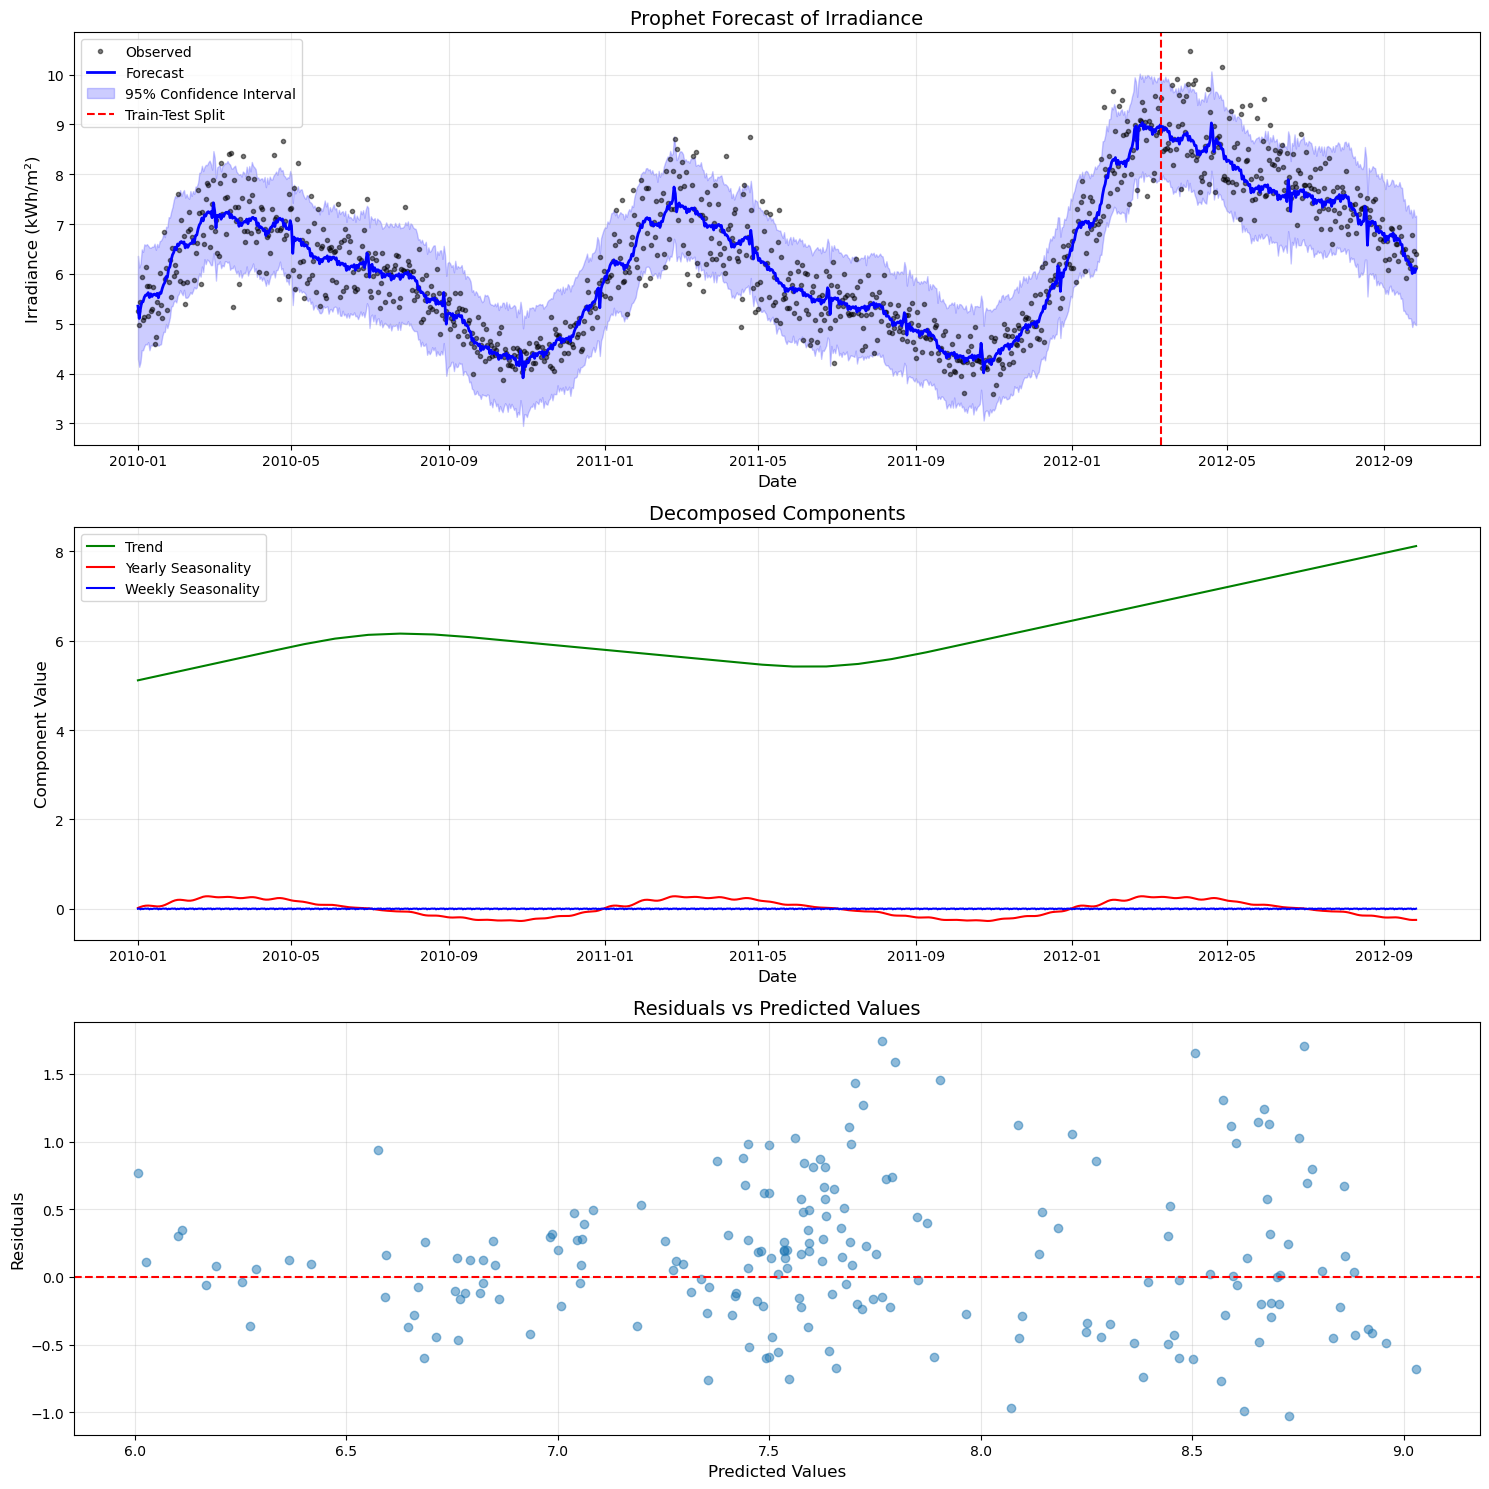

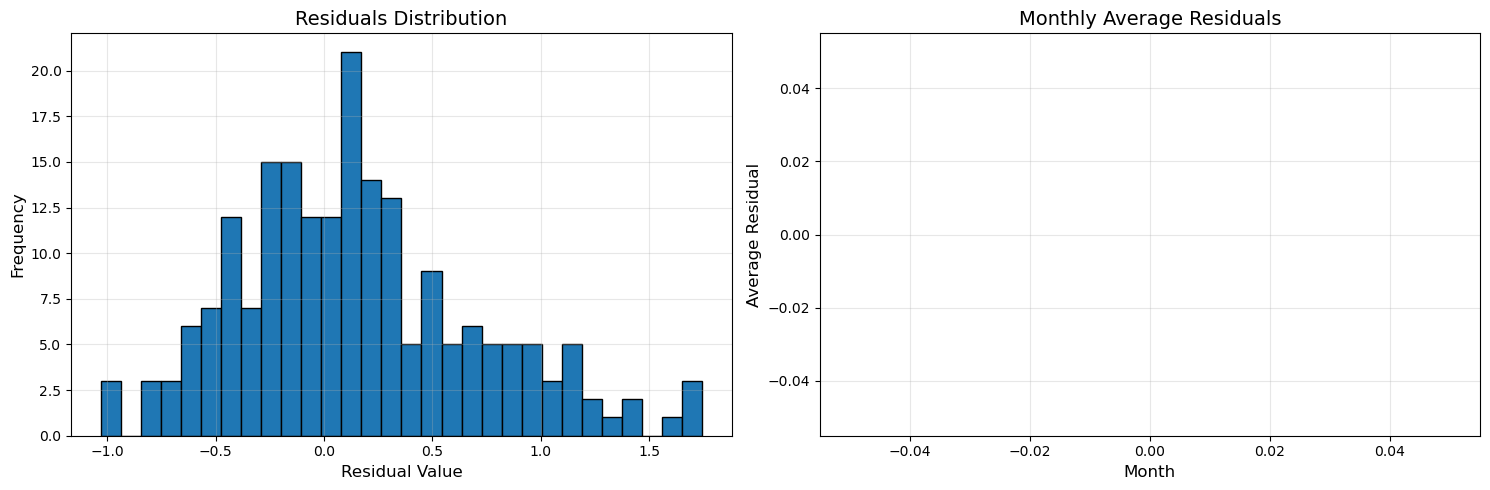

In [4]:

# Set plot style
plt.style.use('default')

# Enhanced data simulation with multiple seasonal components
np.random.seed(42)
n_days = 1000
time = pd.date_range(start='2010-01-01', periods=n_days, freq='D')

# Create more realistic seasonal patterns
day_of_year = np.arange(n_days) % 365
hour_angle = 2 * np.pi * day_of_year / 365

# Yearly seasonality
yearly_seasonality = 5 + 1.5 * np.sin(hour_angle)

# Semi-annual seasonality
semi_annual = 0.5 * np.sin(2 * hour_angle)

# Weather pattern variation (longer-term cycles)
weather_cycle = 0.7 * np.sin(2 * np.pi * np.arange(n_days) / (365 * 2))

# Add realistic trend with some acceleration
trend = 0.002 * np.arange(n_days) + 0.000005 * np.arange(n_days)**1.5

# Add heteroscedastic noise (more variance in summer)
base_noise = np.random.normal(0, 0.5, n_days)
seasonal_volatility = 1 + 0.5 * np.sin(hour_angle)
noise = base_noise * seasonal_volatility

# Combine components
irradiance = yearly_seasonality + semi_annual + weather_cycle + trend + noise

# Create weather features
def create_weather_features(dates, latitude=35.0):
    """Calculate clear sky irradiance and other weather features."""
    day_of_year = dates.dayofyear
    declination = 23.45 * np.sin(2 * np.pi * (day_of_year + 284) / 365)
    hour_angle = np.pi  # Solar noon

    cosine_zen = (np.sin(np.radians(latitude)) * np.sin(np.radians(declination)) +
                 np.cos(np.radians(latitude)) * np.cos(np.radians(declination)) * np.cos(hour_angle))

    clear_sky = np.maximum(0, 1367 * cosine_zen)

    return pd.DataFrame({
        'clear_sky': clear_sky,
        'day_of_year': day_of_year,
        'month': dates.month,
        'day_of_week': dates.dayofweek
    })

# Prepare data with additional features
features = create_weather_features(time)
data = pd.DataFrame({
    'ds': time,
    'y': irradiance,
    'clear_sky': features['clear_sky'],
    'day_of_year': features['day_of_year']
})

# Create holidays and events dataframe
holidays_df = pd.DataFrame({
    'holiday': 'weather_event',
    'ds': pd.date_range(start='2010-01-01', end='2012-12-31', freq='60D'),
    'lower_window': -1,
    'upper_window': 1
})

# Split into training and test sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Configure and fit Prophet model
model = Prophet(
    holidays=holidays_df,
    yearly_seasonality=20,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=15,
    holidays_prior_scale=5,
    interval_width=0.95
)

# Add custom seasonalities and regressors
model.add_seasonality(name='semi_annual', period=365.25/2, fourier_order=5)
model.add_regressor('clear_sky', mode='multiplicative')

# Fit the model
model.fit(train_data)

# Make future predictions
future = model.make_future_dataframe(periods=len(test_data))
future['clear_sky'] = features['clear_sky']
forecast = model.predict(future)

# Extract predictions
test_forecast = forecast.iloc[train_size:].reset_index(drop=True)

# Calculate metrics
def calculate_metrics(actual, predicted):
    """Calculate multiple forecast accuracy metrics."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    r2 = r2_score(actual, predicted)
    return rmse, mape, r2

rmse, mape, r2 = calculate_metrics(test_data['y'], test_forecast['yhat'])

print("\nForecast Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.3f}")

# Modified plotting functions
def plot_forecast_and_analysis(data, forecast, train_size, test_data, test_forecast):
    """Create comprehensive visualization of forecast results."""
    fig = plt.figure(figsize=(15, 15))

    # Plot 1: Overall Forecast
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(data['ds'], data['y'], 'k.', label='Observed', alpha=0.5)
    ax1.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast', linewidth=2)
    ax1.fill_between(forecast['ds'],
                     forecast['yhat_lower'],
                     forecast['yhat_upper'],
                     color='b', alpha=0.2, label='95% Confidence Interval')
    ax1.axvline(data['ds'][train_size], color='r', linestyle='--', label='Train-Test Split')
    ax1.set_title('Prophet Forecast of Irradiance', fontsize=14)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Irradiance (kWh/m²)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Trend and Seasonality
    ax2 = plt.subplot(3, 1, 2)
    ax2.plot(forecast['ds'], forecast['trend'], 'g-', label='Trend')
    ax2.plot(forecast['ds'], forecast['yearly'], 'r-', label='Yearly Seasonality')
    ax2.plot(forecast['ds'], forecast['weekly'], 'b-', label='Weekly Seasonality')
    ax2.set_title('Decomposed Components', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Component Value', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Residuals Analysis
    ax3 = plt.subplot(3, 1, 3)
    residuals = test_data['y'].values - test_forecast['yhat'].values
    ax3.scatter(test_forecast['yhat'], residuals, alpha=0.5)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_title('Residuals vs Predicted Values', fontsize=14)
    ax3.set_xlabel('Predicted Values', fontsize=12)
    ax3.set_ylabel('Residuals', fontsize=12)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional analysis plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Residuals histogram
    ax1.hist(residuals, bins=30, edgecolor='black')
    ax1.set_title('Residuals Distribution', fontsize=14)
    ax1.set_xlabel('Residual Value', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Monthly residuals
    monthly_residuals = pd.Series(residuals, index=test_data['ds']).groupby(
        test_data['ds'].dt.month).mean()
    ax2.plot(monthly_residuals.index, monthly_residuals.values, 'bo-')
    ax2.set_title('Monthly Average Residuals', fontsize=14)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_ylabel('Average Residual', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate plots
plot_forecast_and_analysis(data, forecast, train_size, test_data, test_forecast)